In [1]:
import CommonFunc
import pandas as pd

df = pd.read_csv('resources/CO2Emissions_Canada.csv')


In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Готовим данные
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.preprocessing import LabelEncoder

#удаляем дубликаты
df.drop_duplicates()

#выделяем числовые данные
numdata = pd.DataFrame(df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
                           'CO2 Emissions(g/km)']])

# Делаем энкодинг для категориальных признаков
label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()
label_encoder_3 = LabelEncoder()

vehicle_class = df[['Vehicle Class']].values.ravel()
fuel_type = df[['Fuel Type']].values.ravel()
transmission = df[['Transmission']].values.ravel()

encoded_vehicle_class = label_encoder_1.fit_transform(vehicle_class)
encoded_fuel_type = label_encoder_2.fit_transform(fuel_type)
encoded_transmission = label_encoder_3.fit_transform(transmission)

enc_1 = dict(zip(label_encoder_1.classes_,range(len(label_encoder_1.classes_))))
enc_2 = dict(zip(label_encoder_2.classes_,range(len(label_encoder_2.classes_))))
enc_3 = dict(zip(label_encoder_3.classes_,range(len(label_encoder_3.classes_))))

print(CommonFunc.printDict(enc_1))
print(CommonFunc.printDict(enc_2))
print(CommonFunc.printDict(enc_3))

COMPACT   0
FULL-SIZE   1
MID-SIZE   2
MINICOMPACT   3
MINIVAN   4
PICKUP TRUCK - SMALL   5
PICKUP TRUCK - STANDARD   6
SPECIAL PURPOSE VEHICLE   7
STATION WAGON - MID-SIZE   8
STATION WAGON - SMALL   9
SUBCOMPACT   10
SUV - SMALL   11
SUV - STANDARD   12
TWO-SEATER   13
VAN - CARGO   14
VAN - PASSENGER   15

D   0
E   1
N   2
X   3
Z   4

A10   0
A4   1
A5   2
A6   3
A7   4
A8   5
A9   6
AM5   7
AM6   8
AM7   9
AM8   10
AM9   11
AS10   12
AS4   13
AS5   14
AS6   15
AS7   16
AS8   17
AS9   18
AV   19
AV10   20
AV6   21
AV7   22
AV8   23
M5   24
M6   25
M7   26



In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Составляем матрицу данных X
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

X_ = numdata[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']]
X_['Vehicle Class'] = encoded_vehicle_class
X_['Transmission'] = encoded_transmission
X_['Fuel Type'] = encoded_fuel_type
feature_names = X_.columns
X=X_.values

#Составляем и упрощаем до одномерного массива набор целевой переменной
y = numdata[['CO2 Emissions(g/km)']].values.ravel()

*****************
Метрики качества:
*****************
MAE: 1.7160103232
MSE: 7.2211825695
RMSE: 2.6872258129
R²: 0.9979005916


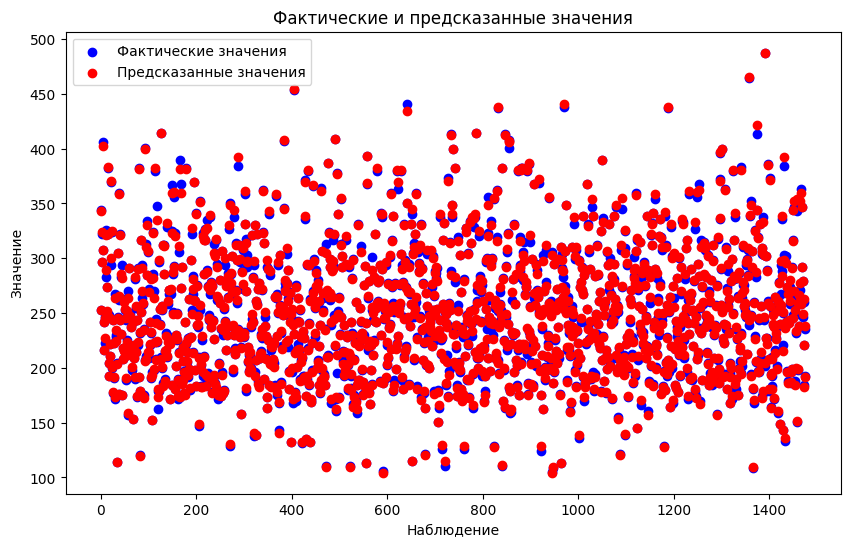

C:\Users\Alwx\Desktop\PythonProjects\Homework5\CommonFunc.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


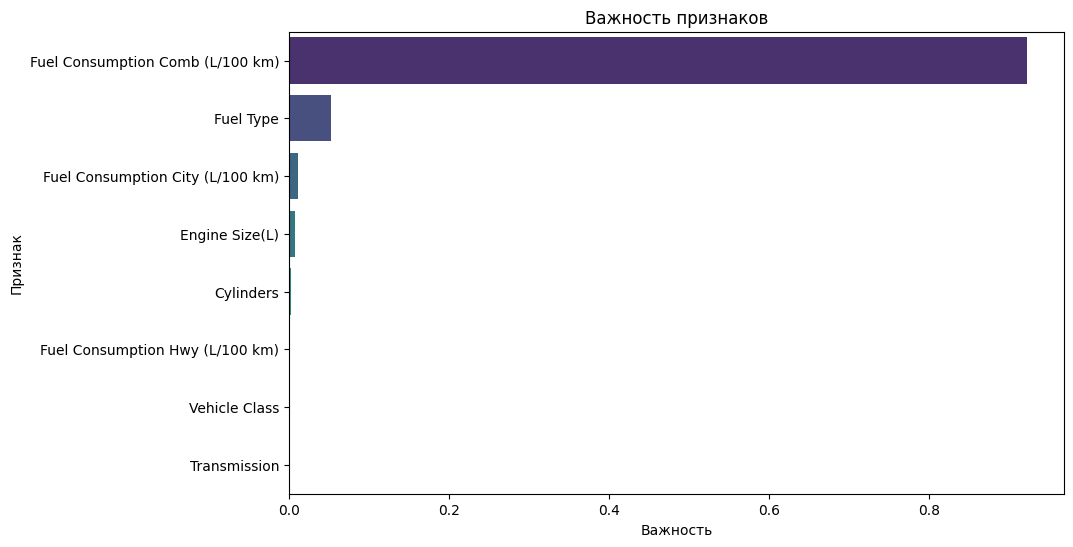

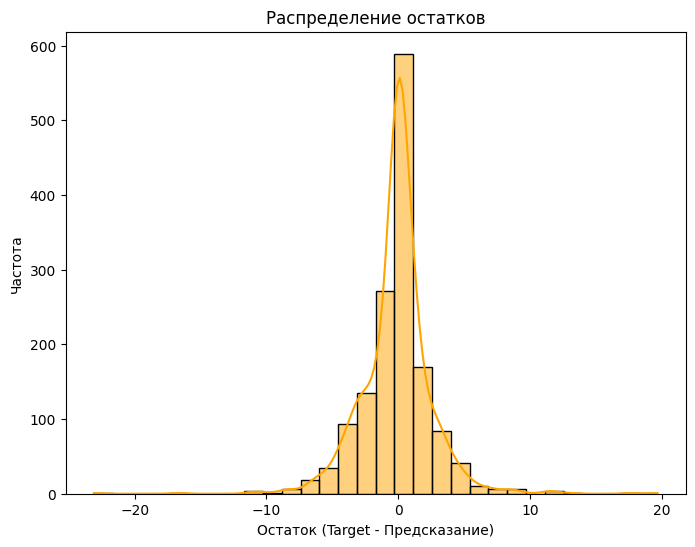

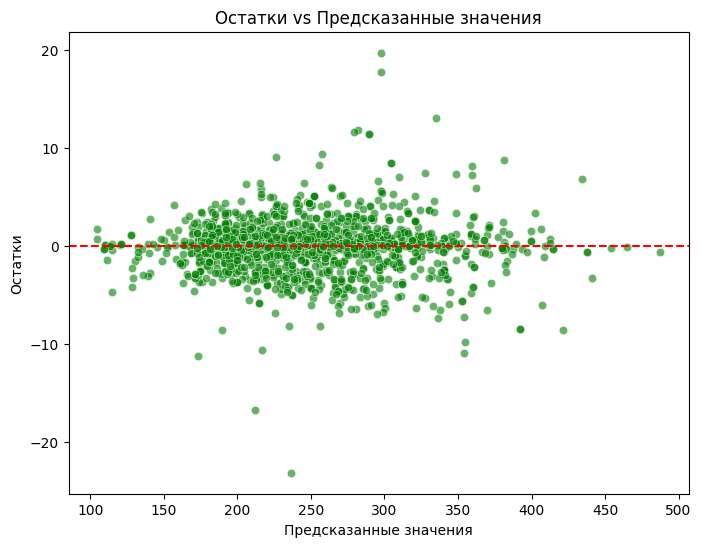

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Простой Random Forest на всех колонках
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Используем Random Forest чтобы найти наиболее важные признаки
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

# Важность признаков
CommonFunc.getImportances(rfr.feature_importances_, feature_names)

# Остатки
CommonFunc.getRemains(y_test, y_pred)


In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#дропаем не влияющие на результат колонки
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

X_ = X_.drop(columns=['Fuel Consumption Hwy (L/100 km)', 'Transmission', 'Cylinders', 'Vehicle Class'])
X=X_.values

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
*****************
Метрики качества:
*****************
MAE: 2.1412717682
MSE: 8.9661339905
RMSE: 2.9943503453
R²: 0.9973932834


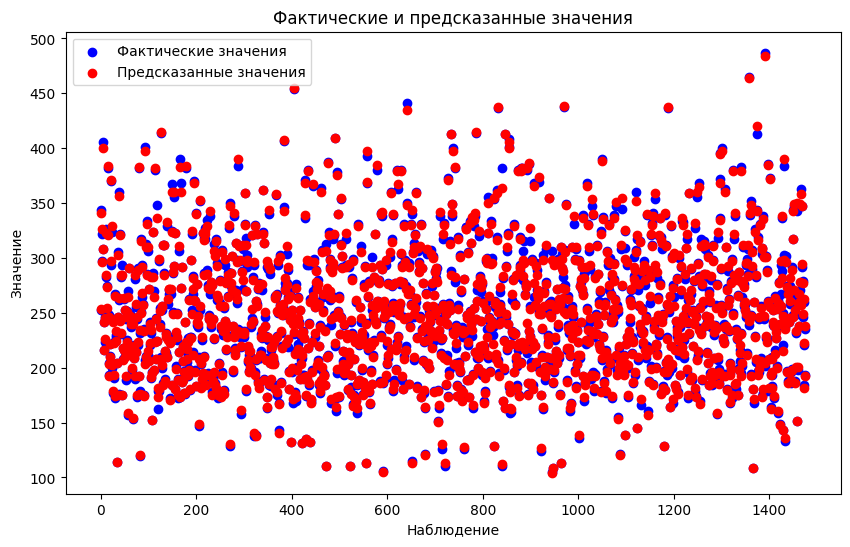

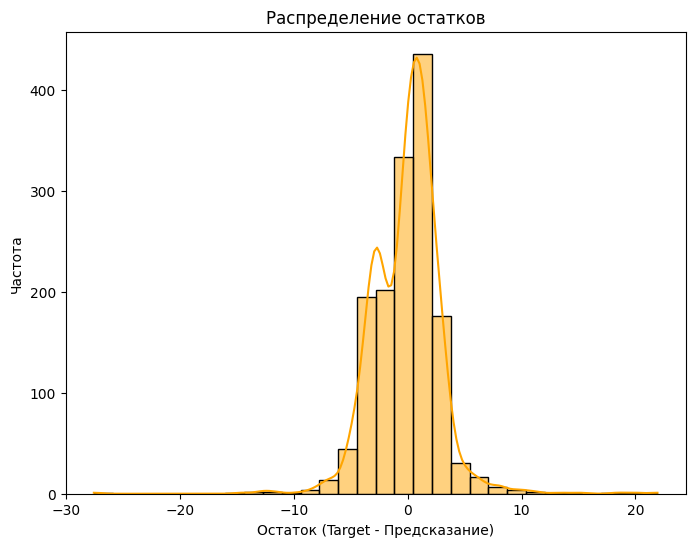

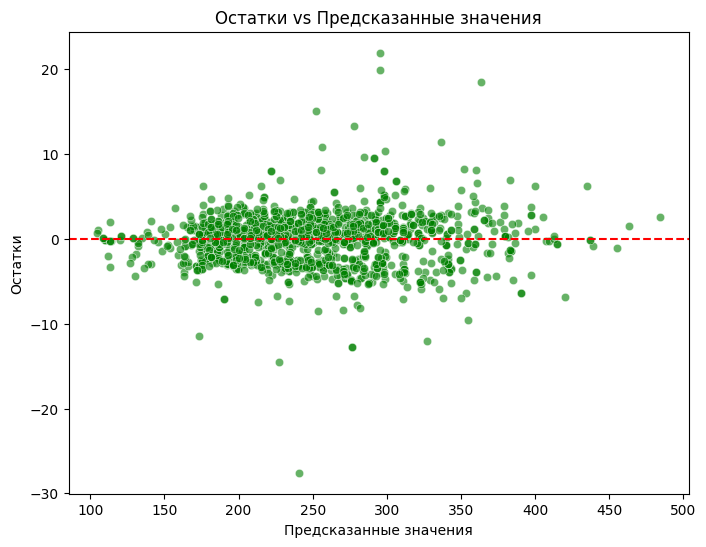

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Random Forest Regressor с использованием GridSearchCV
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_data_part_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 2.5164903901
MSE: 11.0218322054
RMSE: 3.3199144877
R²: 0.9967956319


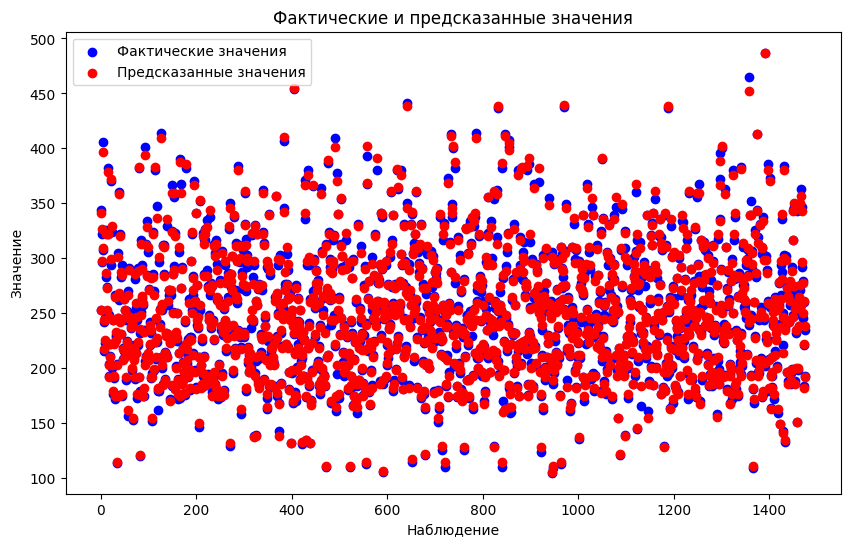

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Gradient Boosting Regressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

gbr_metrics = CommonFunc.getMetrics(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 5908, number of used features: 4
[LightGBM] [Info] Start training from score 250.939573
*****************
Метрики качества:
*****************
MAE: 2.2945381170
MSE: 11.9530359634
RMSE: 3.4573162950
R²: 0.9965249039


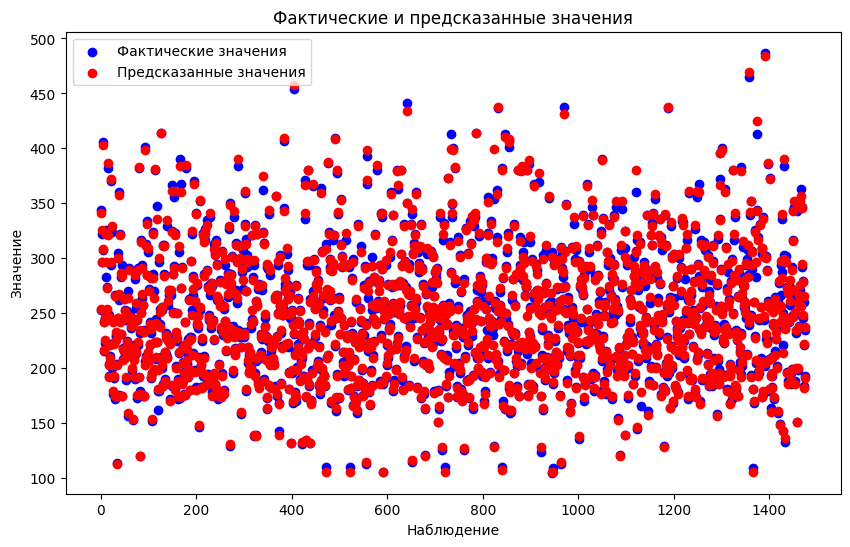

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#LGBMRegressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from lightgbm import LGBMRegressor

lgbm = LGBMRegressor() # параметры
lgbm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lgbm.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 2.0220564246
MSE: 8.9301945591
RMSE: 2.9883431127
R²: 0.9974037409


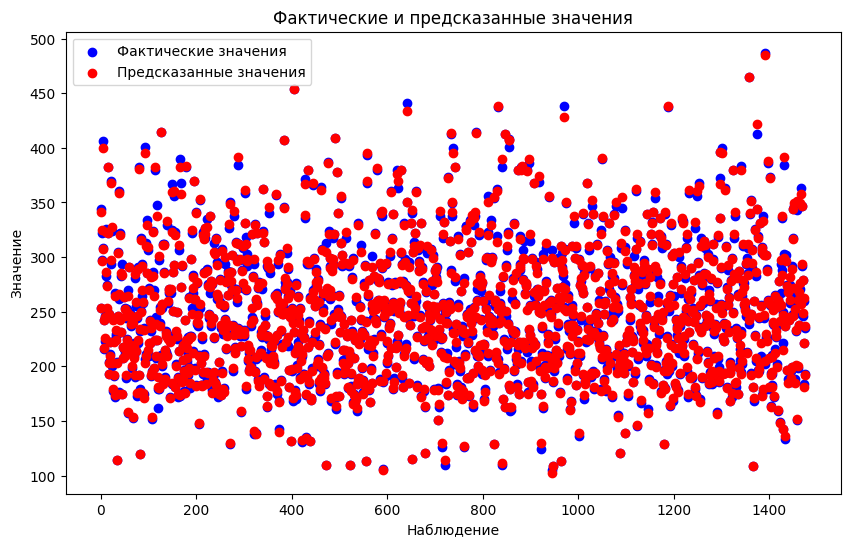

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#XGB Regressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from xgboost import XGBRegressor

xgb = XGBRegressor() # параметры
xgb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
xgb_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 13.1237273299
MSE: 379.1783578997
RMSE: 19.4725026101
R²: 0.8897617933


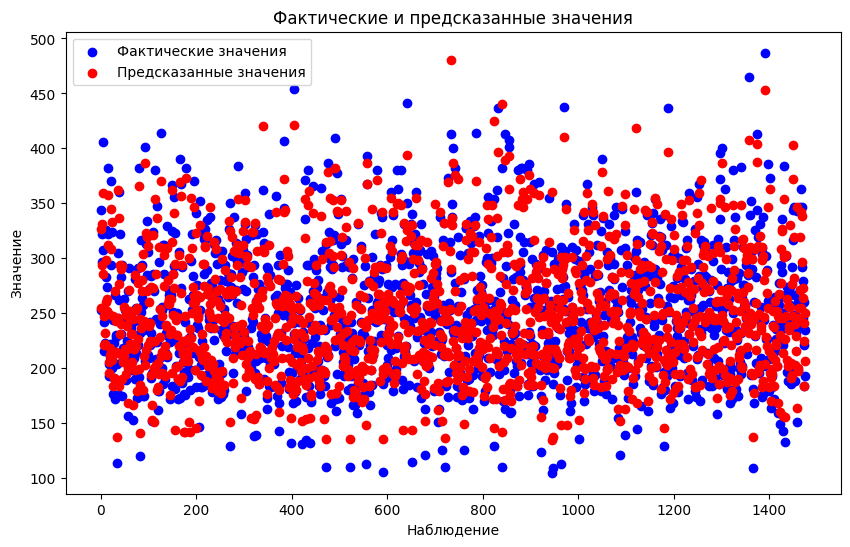

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Elastic net
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from sklearn.linear_model import ElasticNet

par = ElasticNet(alpha=0.2, l1_ratio=0.7, random_state=42) # параметры
par.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = par.predict(X_test)

# Вычисление метрик
par_metrics = CommonFunc.getMetrics(y_test, y_pred)


*****************
Метрики качества:
*****************
MAE: 12.9370330417
MSE: 377.2253724915
RMSE: 19.4222906088
R²: 0.8903295831


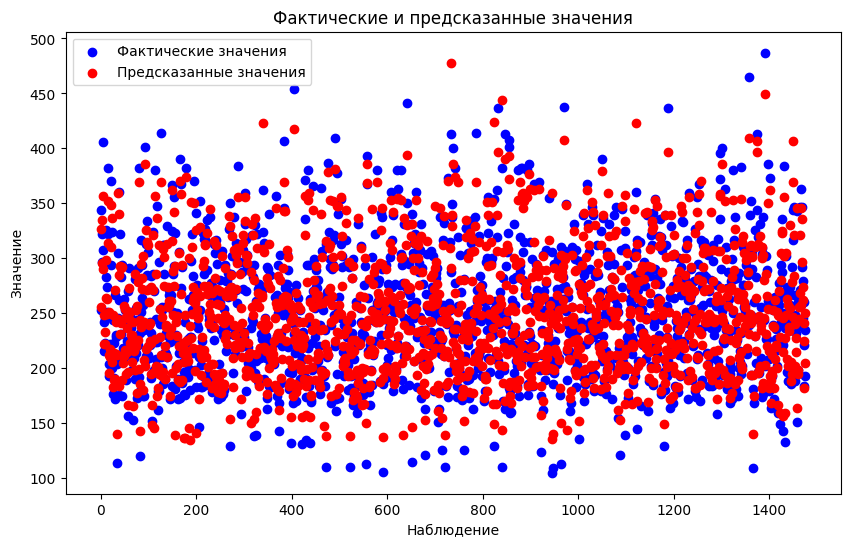

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Huber regressor
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(epsilon=5) # параметры
huber.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = huber.predict(X_test)

# Вычисление метрик
huber_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 14.2181980942
MSE: 549.5829478049
RMSE: 23.4431855302
R²: 0.8402202095


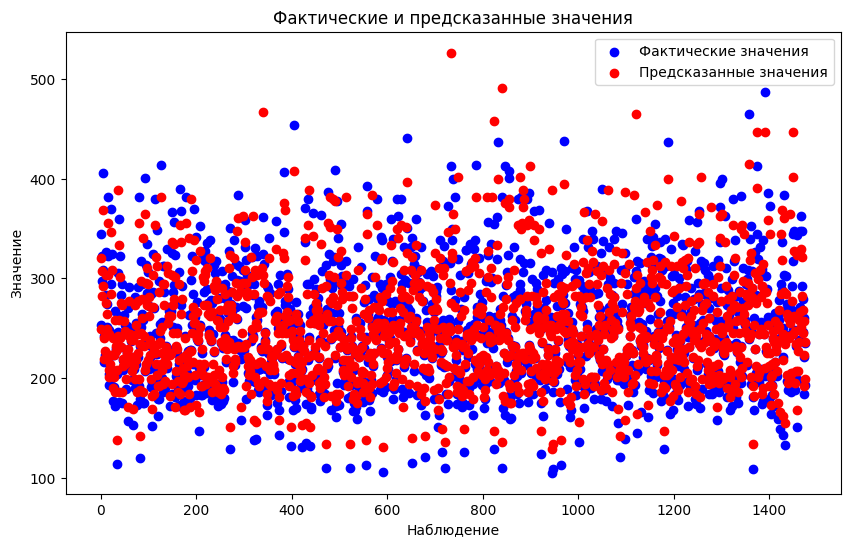

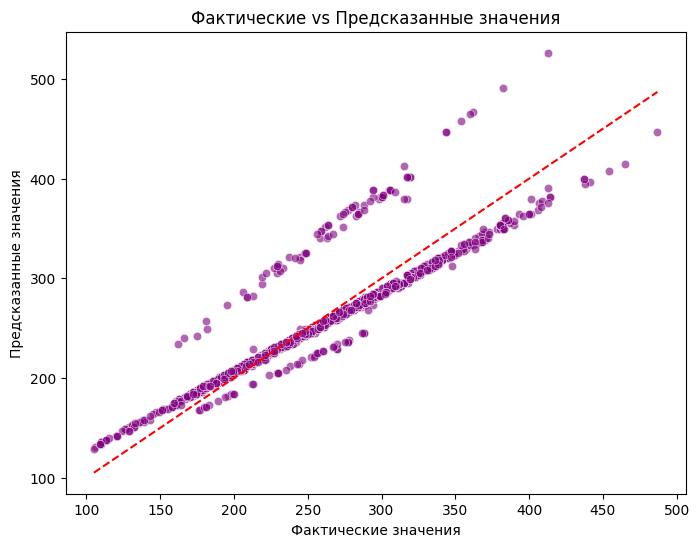

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Линейная регресия для одной колонки
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

X = numdata[['Fuel Consumption Comb (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

lr = LinearRegression() 
lr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lr.predict(X_test)

# Вычисление метрик
lr_metrics = CommonFunc.getMetrics(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения')
plt.show()

*****************
Метрики качества ['Z', 'X']:
*****************
MAE: 2.2035126606
MSE: 7.1102050118
RMSE: 2.6664967676
R²: 0.9979171154

*****************
Метрики качества ['D']:
*****************
MAE: 1.5455787541
MSE: 3.9375442601
RMSE: 1.9843246358
R²: 0.9981298921

*****************
Метрики качества ['E']:
*****************
MAE: 5.3378657082
MSE: 36.1256891478
RMSE: 6.0104649694
R²: 0.9786811176

*****************
Метрики качества:
*****************
MAE: 2.2785087808
MSE: 8.7308241310
RMSE: 2.9547968003
R²: 0.9974497689


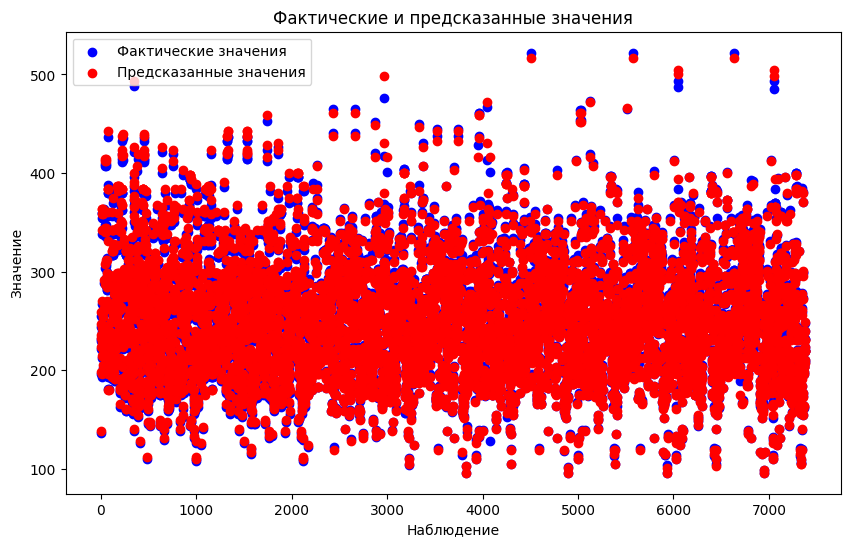

In [13]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Линейная регресия с разделением на типы топлива. Обучаем три разных модели Линейний регресии в зависимости от типа топлива.
#X-Бензин высокого качества
#Z-Бензин низкого качества
#D-дизель
#E-этанол
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def LinearRegressionForVariousFuelType(fuel_types: list):
    new_df = df[df['Fuel Type'].isin(fuel_types)]
    
    X = new_df[['Fuel Consumption Comb (L/100 km)']]
    y = new_df[['CO2 Emissions(g/km)']].values.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    model = RandomForestRegressor() 
    
    lr = LinearRegression() 
    lr.fit(X_train, y_train)
    
    # Предсказание на тестовой выборке
    y_pred = lr.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'*****************')
    print('Метрики качества ' + fuel_types.__str__() + ':')
    print(f'*****************')
    print(f'MAE: {mae:.10f}')
    print(f'MSE: {mse:.10f}')
    print(f'RMSE: {rmse:.10f}')
    print(f'R²: {r2:.10f}')
    print('')
    return lr 

lrXZ = LinearRegressionForVariousFuelType(['Z','X'])
lrD = LinearRegressionForVariousFuelType(['D'])
lrE = LinearRegressionForVariousFuelType(['E'])




def predictionLRDiffFuelType(fuel_type, fuel_consumption):
    if fuel_type == 'Z' or fuel_type == 'X':
       return lrXZ.predict(((fuel_consumption,),))[0]
    if fuel_type == 'D':
       return lrD.predict(((fuel_consumption,),))[0]
    if fuel_type == 'E':
       return lrE.predict(((fuel_consumption,),))[0]




new_df = df[df['Fuel Type'] !='N']
X = new_df[['Fuel Consumption Comb (L/100 km)', 'Fuel Type']]
y = new_df[['CO2 Emissions(g/km)']].values.ravel()
y_pred = []

for x_x in X.values:
    y_pred.append(predictionLRDiffFuelType(x_x[1], x_x[0]))

lr_fueltype_metrics = CommonFunc.getMetrics(y, y_pred)    


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 1, 'min_samples_split': 20, 'n_estimators': 100}
*****************
Метрики качества:
*****************
MAE: 8.5071780349
MSE: 392.5682337658
RMSE: 19.8133347462
R²: 0.8858689659


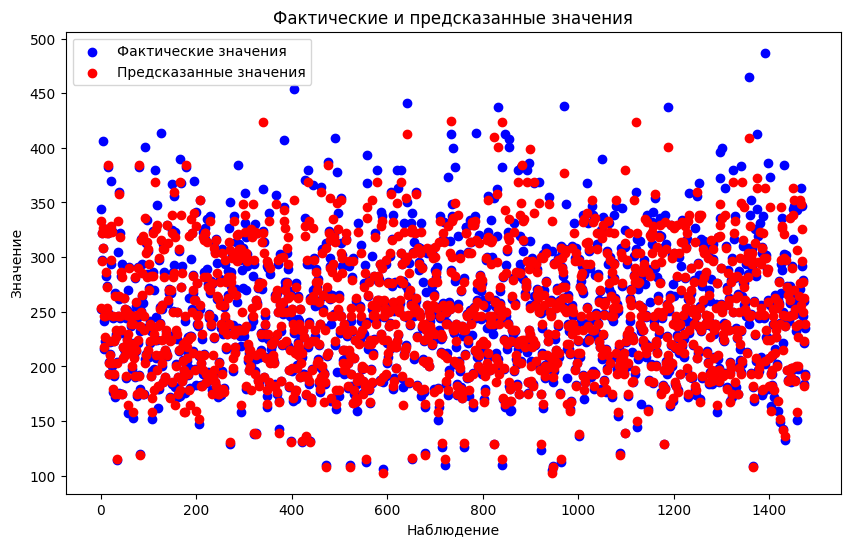

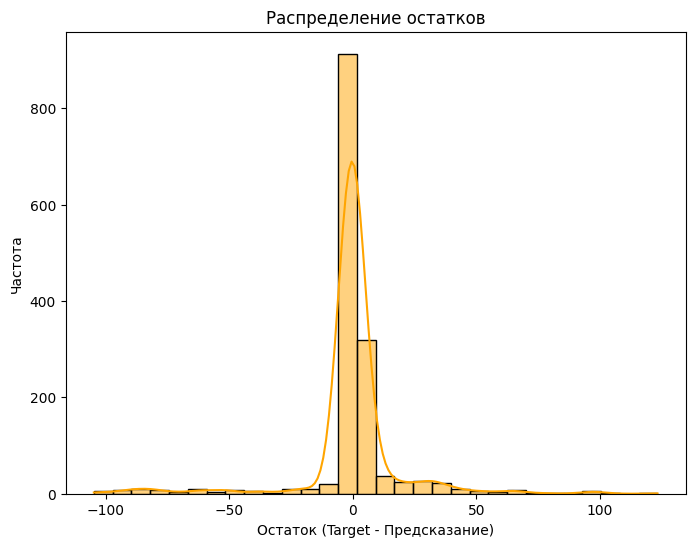

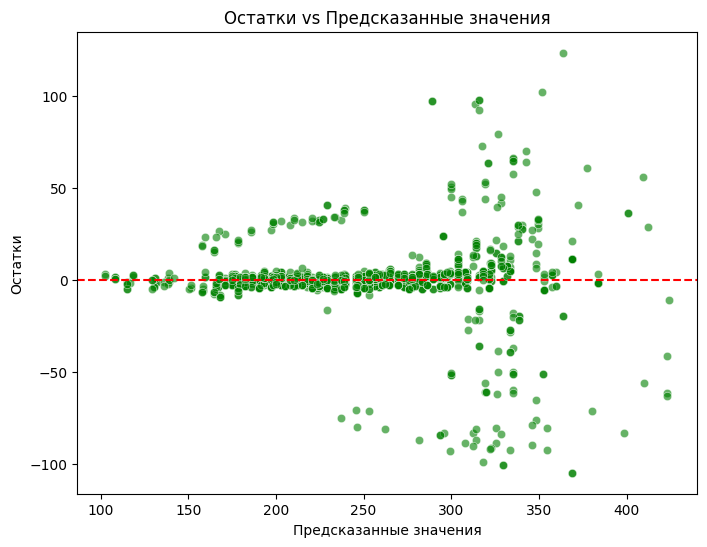

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Рандом форест для одной колонки
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.model_selection import GridSearchCV


X = numdata[['Fuel Consumption Comb (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_fc = RandomForestRegressor(**best_params) 
rfr_fc.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_fc.predict(X_test)

# Вычисление метрик
rfr_fc_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

Best parameters found: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
*****************
Метрики качества:
*****************
MAE: 26.0441245623
MSE: 1271.6808988262
RMSE: 35.6606351433
R²: 0.6302852764


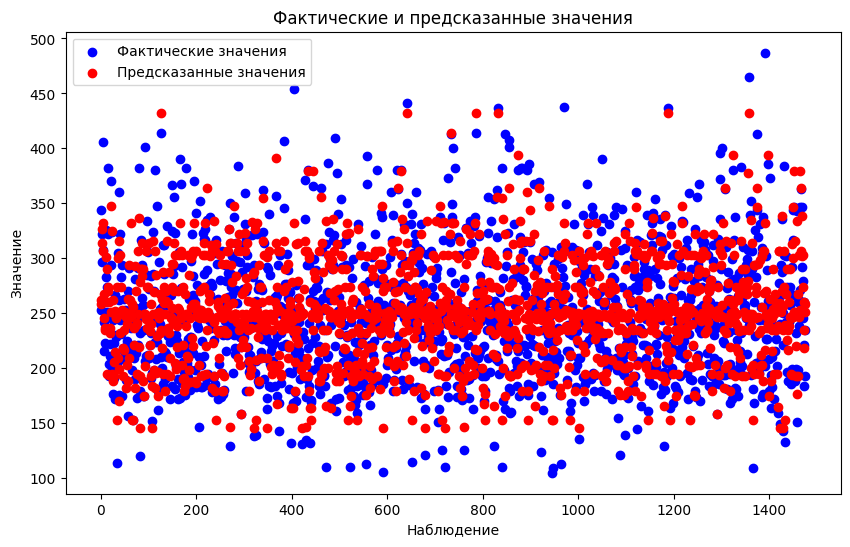

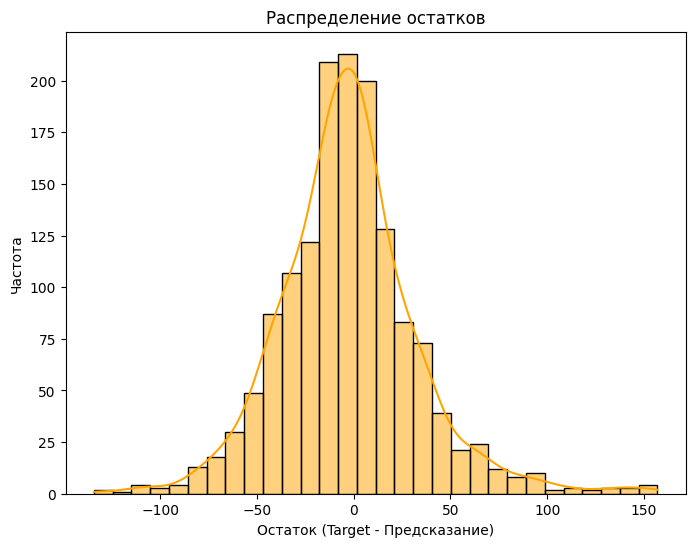

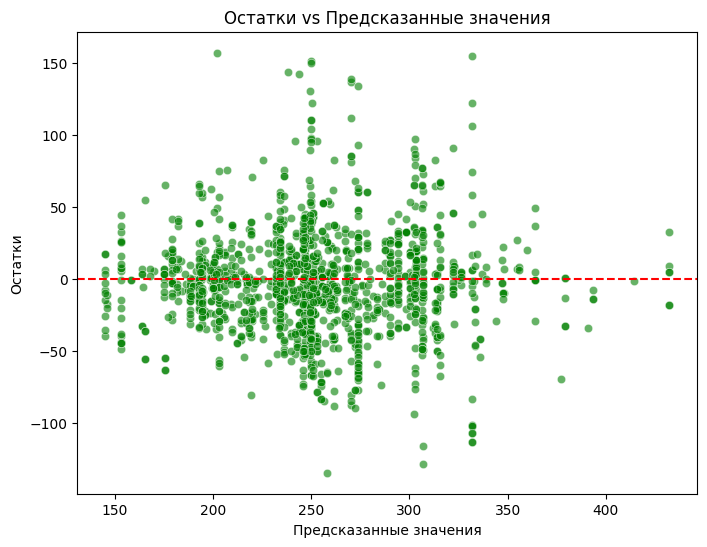

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Рандом форест только для категориальных признаков (просто интересно стало)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

X = pd.DataFrame()
X['Vehicle Class'] = encoded_vehicle_class
X['Transmission'] = encoded_fuel_type
X['Fuel Type'] = encoded_transmission

y = numdata[['CO2 Emissions(g/km)']].values.ravel()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Создание и обучение модели Gradient Boosting Regressor
rfr_cat = RandomForestRegressor(**best_params) # параметры
rfr_cat.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr_cat.predict(X_test)

# Вычисление метрик
rfr_cat_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

In [16]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#мой автомобиль (гугл пишет что 149 - 191 г/км)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

my_y = xgb.predict(((6.0,0,7.5,2.0),))
print(my_y[0]) 

my_y_2 = predictionLRDiffFuelType('D', 6.0)
print(my_y_2)

172.87692
161.2974357756826


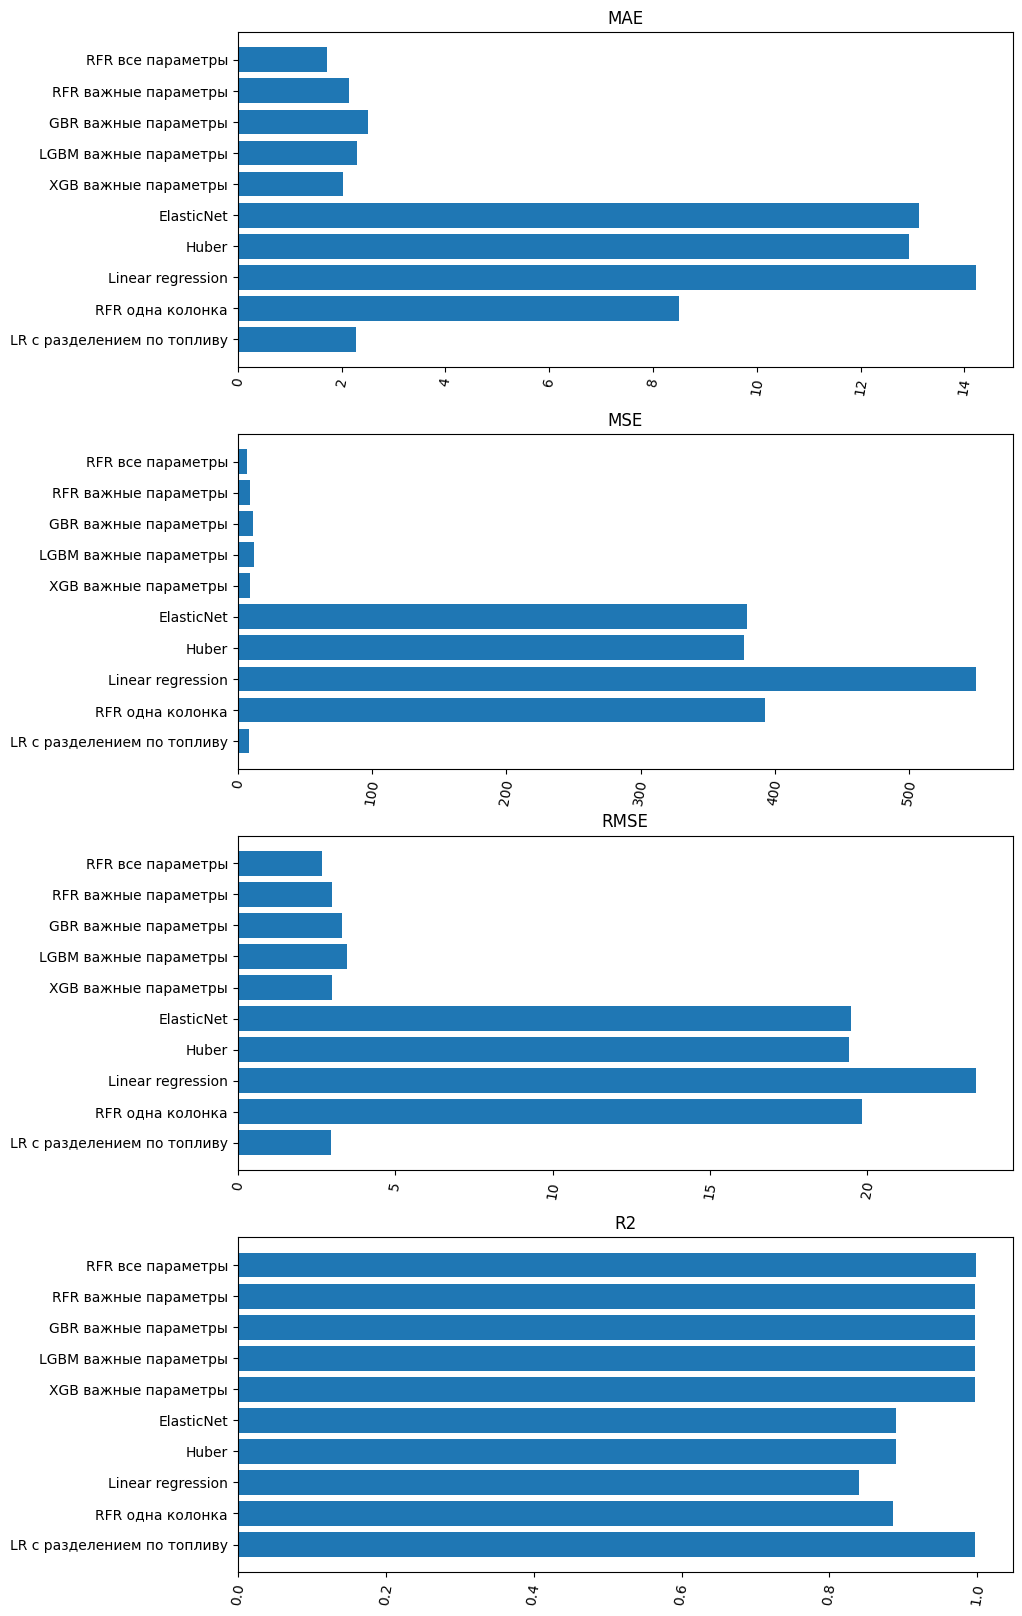

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Визуализация метрик
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import matplotlib.pyplot as plt

names =('RFR все параметры', 'RFR важные параметры', 'GBR важные параметры', 'LGBM важные параметры', 
        'XGB важные параметры', 'ElasticNet', 'Huber', 'Linear regression','RFR одна колонка', 'LR с разделением по топливу')

mae = (rfr_metrics[0], rfr_data_part_metrics[0], gbr_metrics[0], lgbm_metrics[0], xgb_metrics[0], par_metrics[0], huber_metrics[0], lr_metrics[0], rfr_fc_metrics[0], lr_fueltype_metrics[0])
mse = (rfr_metrics[1], rfr_data_part_metrics[1], gbr_metrics[1], lgbm_metrics[1], xgb_metrics[1], par_metrics[1], huber_metrics[1], lr_metrics[1], rfr_fc_metrics[1], lr_fueltype_metrics[1])
rmse = (rfr_metrics[2], rfr_data_part_metrics[2], gbr_metrics[2], lgbm_metrics[2], xgb_metrics[2], par_metrics[2], huber_metrics[2], lr_metrics[2], rfr_fc_metrics[2], lr_fueltype_metrics[2])
r2 = (rfr_metrics[3], rfr_data_part_metrics[3], gbr_metrics[3], lgbm_metrics[3], xgb_metrics[3], par_metrics[3], huber_metrics[3], lr_metrics[3], rfr_fc_metrics[3], lr_fueltype_metrics[3])

fig, axs = plt.subplots(4, 1)
fig.set_figheight(20)
fig.set_figwidth(10)

axs[0].title.set_text('MAE')
axs[0].tick_params(axis='x', rotation=80)
axs[0].barh(names, mae)
axs[0].invert_yaxis()

axs[1].title.set_text('MSE')
axs[1].tick_params(axis='x', rotation=80)
axs[1].barh(names, mse)
axs[1].invert_yaxis()

axs[2].title.set_text('RMSE')
axs[2].tick_params(axis='x', rotation=80)
axs[2].barh(names, rmse)
axs[2].invert_yaxis()

axs[3].title.set_text('R2')
axs[3].tick_params(axis='x', rotation=80)
axs[3].barh(names, r2)
axs[3].invert_yaxis()
